# Best Practices
Julian Hsu

Simulated evidence for different ways to deal with propensity trimming.


In [4]:
import pandas as pd
import numpy as np
import os as os 

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.conditional_models import ConditionalLogit

from IPython.display import display    


import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error


In [5]:
import stnomics as st

## Create a function that will guarantee generating extremely large and small propensity scores

In [82]:
from scipy import stats 

In [101]:
def generate_exdata(TrueEstimate=10):
    N = 1000
#     x = np.random.uniform(0,1,N)
    
#     ## Force it to be a near uniform distribution
#     treatment_latent = np.zeros_like(x)
#     for r in np.arange(0.01,1,0.01):
#         upper = df['x'].quantile(r)
#         lower = df['x'].quantile(r-0.01)
#         treatment_latent[ (x>=lower) & (x < upper) ] = r + np.random.uniform(-0.01,0.01, len(treatment_latent[ (x>=lower) & (x < upper) ]) )
    
    x = stats.beta.rvs(a=0.15,b=0.15,size=N)
    treatment_latent = x[:]
    treatment = (treatment_latent > np.random.uniform(0,1,N)).astype(float)
    Y = TrueEstimate*treatment + np.random.uniform(-1,1)*x+np.random.normal(0,1,N)
    return pd.DataFrame(data={'x':x, 'y':Y, 'W':treatment, 'W_x':treatment_latent})

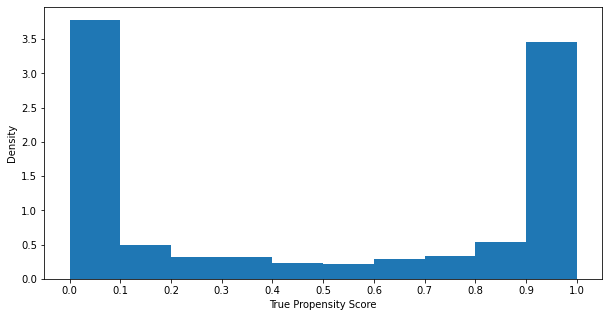

In [104]:
df =generate_exdata(TrueEstimate=5)
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,5))
ax.hist(df['W_x'], density=True)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_xlabel('True Propensity Score')
ax.set_ylabel('Density')
fig.set_facecolor('white')

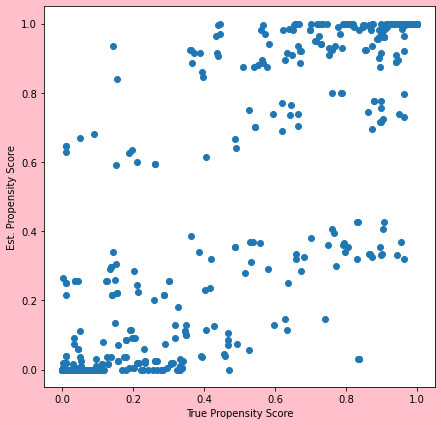

In [105]:
st.block_splits(df, split_name='splits', n_data_splits=4)
df['W_hat'] = st.predict_treatment_indicator(df, 'splits',4, ['x'], 'W', RandomForestClassifier(n_estimators=200, random_state=27) )
fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(7,7,))
ax.scatter(df['W_x'], df['W_hat'])
ax.set_xlabel('True Propensity Score')
ax.set_ylabel('Est. Propensity Score')
fig.set_facecolor('pink')

In [133]:
aux_dict = {'lower':0, 'upper':1, 'bootstrapreps':10}

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


0.260


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


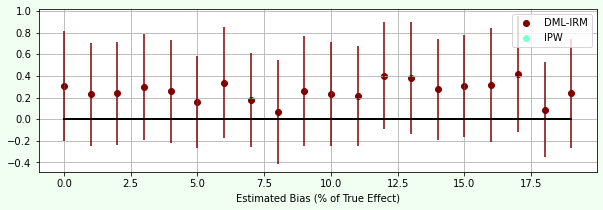

In [142]:
dml_irm_est_bias = []
dml_irm_se_bias = []

ipw_est_bias = []
ipw_se_bias = []

n_sim_list = range(20)
for r in n_sim_list:
    df =generate_exdata(TrueEstimate=5)
    df_subset = df.loc[df['W_x'].between(0.01, 0.99)]
    a=st.ate.dml.dml_irm(df_subset, 
                    'splits', ['x'], 'y', 'W',
                    RandomForestRegressor(n_estimators=200, random_state=27),
                    RandomForestClassifier(n_estimators=200, random_state=27),
                   4,
                   aux_dict)
    dml_irm_est_bias.append( (a['ATT TE']-5)/5 )
    dml_irm_se_bias.append(a['ATT SE'])

    a= st.ate.ipw(df_subset, 
                    'splits', ['x'], 'y', 'W',
                    RandomForestRegressor(n_estimators=200, random_state=27),
                    RandomForestClassifier(n_estimators=200, random_state=27),
                   4,
                   aux_dict)
    ipw_est_bias.append( (a['ATT TE']-5)/5 )
    ipw_se_bias.append(a['ATT SE'])

## Make the lists arrays for plotting purposes    
dml_irm_est_bias = np.array(dml_irm_est_bias)    
dml_irm_se_bias = np.array(dml_irm_se_bias)

ipw_est_bias = np.array(ipw_est_bias)    
ipw_se_bias = np.array(ipw_se_bias)

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(10,3))
ax.scatter(n_sim_list, dml_irm_est_bias, color='maroon', label='DML-IRM')
ax.vlines(n_sim_list, 
                     dml_irm_est_bias-1.96*dml_irm_se_bias,
                     dml_irm_est_bias+1.96*dml_irm_se_bias, 
                     color='maroon')

ax.scatter(n_sim_list, ipw_est_bias, color='aquamarine', label='IPW')
ax.vlines(n_sim_list, 
                     ipw_est_bias-1.96*ipw_se_bias,
                     ipw_est_bias+1.96*ipw_se_bias, 
                     color='aquamarine')

ax.plot(n_sim_list, np.zeros_like(n_sim_list), color='black', linewidth=2)
ax.set_xlabel('Estimated Bias (% of True Effect)')
ax.legend()
ax.grid()
print('{0:5.3f}'.format(np.average(dml_irm_est_bias) ))

fig.set_facecolor('honeydew')

In [143]:
print(ipw_est_bias[0:5])
print(dml_irm_est_bias[0:5])

[nan nan nan nan nan]
[0.30545037 0.22989023 0.23821881 0.30034617 0.2571569 ]


### Apply with a linearized model
We will find the bias is smaller, but the drawback is additional restrictions

0.018


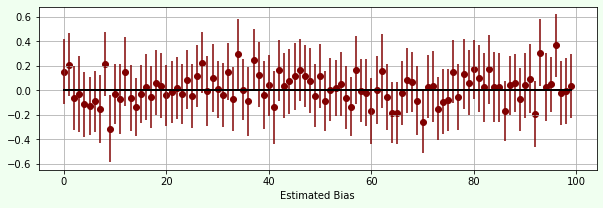

In [139]:
ols_est_bias = []
ols_se_bias = []
n_sim_list = range(100)
for r in n_sim_list:
    df =generate_exdata(TrueEstimate=5)
    df_subset = df.loc[df['W_x'].between(0.01,0.99 )]
    a=st.ate.ols_vanilla(df_subset, 
                    'splits', ['x'], 'y', 'W',
                    RandomForestRegressor(n_estimators=200, random_state=27),
                    RandomForestClassifier(n_estimators=200, random_state=27),
                   4,
                   aux_dict)
    ols_est_bias.append(a['ATT TE']-5)
    ols_se_bias.append(a['ATT SE'])
    
ols_est_bias = np.array(ols_est_bias)    
ols_se_bias = np.array(ols_se_bias)

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(10,3))
ax.scatter(n_sim_list, ols_est_bias, color='maroon')
ax.vlines(n_sim_list, ols_est_bias+1.96*ols_se_bias, 
                     ols_est_bias-1.96*ols_se_bias,
                     color='maroon')
ax.plot(n_sim_list, np.zeros_like(n_sim_list), color='black', linewidth=2)
ax.set_xlabel('Estimated Bias')
ax.grid()
print('{0:5.3f}'.format(np.average(ols_est_bias) ))

fig.set_facecolor('honeydew')